In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.metrics import confusion_matrix
import shap


from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss, TomekLinks

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = 'ignore', category = UserWarning)
warnings.simplefilter(action = 'ignore', category = RuntimeWarning)

c:\Users\user\miniconda3\envs\hospitality_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [53]:
data = pd.read_csv(r"C:\Users\user\Desktop\Github\Bank Churn Prediction\Bank-Churn-Prediction\data\cleaned_encoded_v2.csv")

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9500 entries, 0 to 9499
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerId         9500 non-null   int64  
 1   Surname            9500 non-null   object 
 2   CreditScore        9500 non-null   float64
 3   Age                9500 non-null   float64
 4   Tenure             9500 non-null   float64
 5   Balance            9500 non-null   float64
 6   NumOfProducts      9500 non-null   float64
 7   HasCrCard          9500 non-null   float64
 8   IsActiveMember     9500 non-null   float64
 9   EstimatedSalary    9500 non-null   float64
 10  Geography_France   9500 non-null   bool   
 11  Geography_Germany  9500 non-null   bool   
 12  Geography_Spain    9500 non-null   bool   
 13  Gender_Female      9500 non-null   bool   
 14  Gender_Male        9500 non-null   bool   
 15  Exited             9500 non-null   int64  
dtypes: bool(5), float64(8), 

In [54]:
X = data.drop(columns=['Exited', 'Surname', 'CustomerId'], axis=1)
y = data['Exited']

In [11]:
# Select the best model 

def best_pipeline (X, y , models:list, sample_methods:list, scoring_type:str, n:int):
    
    
    pipe = Pipeline([
        ('select_k_best', SelectKBest(score_func=f_classif, k=n)),
        ('sampling', SMOTE()),  # Placeholder
        ('model', RandomForestClassifier())  # Placeholder
    ])
        

    params = [{
        "model": models,
        "sampling":sample_methods
    }]


    CV= GridSearchCV(pipe, params,scoring = scoring_type, verbose = 1, cv = 5, n_jobs = -1,)
    CV.fit(X,y)
    
    #total elapsed time
    mean_fit_time= CV.cv_results_['mean_fit_time']
    mean_score_time= CV.cv_results_['mean_score_time']
    n_iter = pd.DataFrame(CV.cv_results_).shape[0] #Iterations per split

    
    best_score = CV.best_score_
    best_estimator = CV.best_estimator_
    
    print("Total elapsed time (mins): ", round(np.mean(mean_fit_time + mean_score_time) * n_iter/60,4))
    print("#"*50)
    print("Best score is: ", round(best_score,4))
    print("#"*50)
    print("Best estimator : ",best_estimator)

    #Creating a dataframe with the scores of each pipeline
    df_results = pd.DataFrame(CV.cv_results_)
    
    df_scores = pd.DataFrame(columns=["full_model", "score", "rank" ,"model", "sampling","params"])
    df_scores["params"] = df_results["params"]
    df_scores["score"] = df_results["mean_test_score"]
    df_scores["rank"] = df_results["rank_test_score"]
    df_scores["model"] = df_scores["params"].apply(lambda x: str(x["model"]))  
    df_scores["sampling"] = df_scores["params"].apply(lambda x: str(x["sampling"]))
    df_scores["full_model"] = df_scores["model"]+"||"+df_scores["sampling"]
   
    df_scores.drop(columns="params",inplace=True)
    df_scores = df_scores.sort_values(by='score', ascending=False)
    
   

    #Access the SelectKBest step from the pipeline
    select_k_best = best_estimator.named_steps['select_k_best']

    #Get a boolean mask of the selected features
    feature_mask = select_k_best.get_support()

    selected_features = X.columns[feature_mask]
    print("Selected features:", selected_features)

    #Barplot
    plt.figure(figsize=(8,8))
    ax = sns.barplot(x='score', y="full_model", 
                     data=df_scores, palette='pastel')
    
    for container in ax.containers:
        ax.bar_label(container, label_type='center')
    
    plt.show()
    
    return df_scores

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Total elapsed time (mins):  0.6171
##################################################
Best score is:  0.862
##################################################
Best estimator :  Pipeline(steps=[('select_k_best', SelectKBest(k=12)), ('sampling', SMOTE()),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x00000259CE5E4EE0>)])
Selected features: Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'Geography_France', 'Geography_Germany',
       'Geography_Spain', 'Gender_Female', 'Gender_Male'],
      dtype='object')


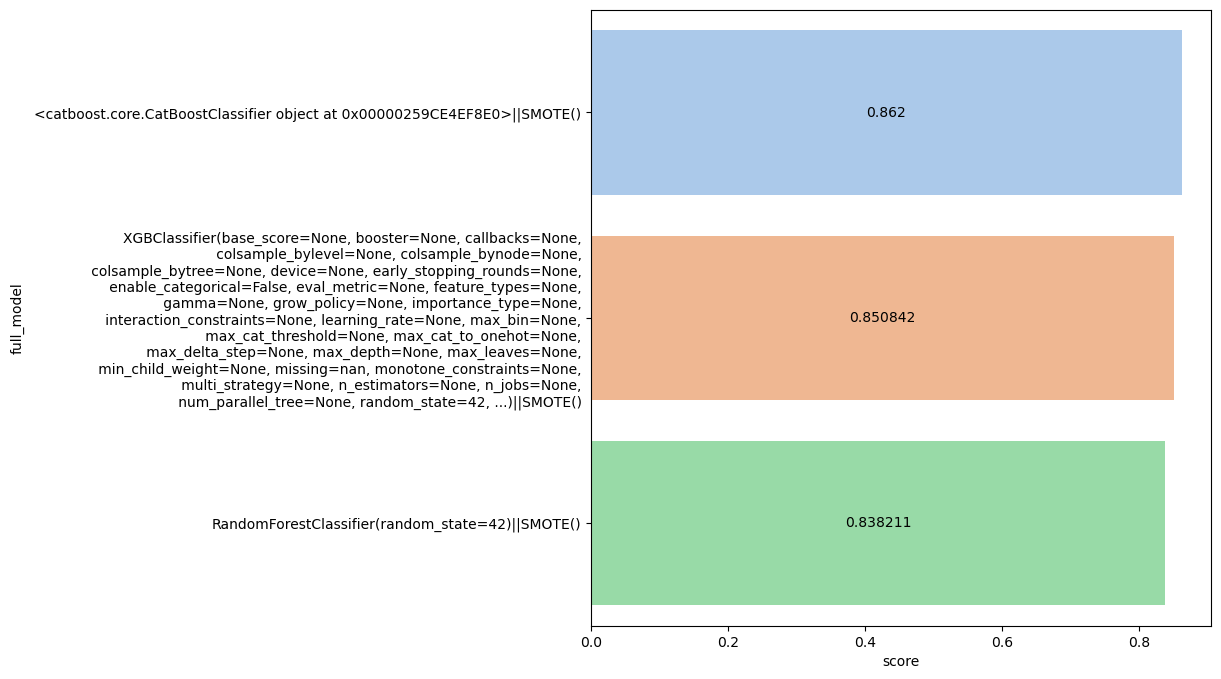

,full_model,score,rank,model,sampling
2,<catboost.core.CatBoostClassifier object at 0x...,0.862000,1,<catboost.core.CatBoostClassifier object at 0x...,SMOTE()
0,"XGBClassifier(base_score=None, booster=None, c...",0.850842,2,"XGBClassifier(base_score=None, booster=None, c...",SMOTE()
1,RandomForestClassifier(random_state=42)||SMOTE(),0.838211,3,RandomForestClassifier(random_state=42),SMOTE()


In [18]:
model_list=[XGBClassifier(random_state=42), RandomForestClassifier(random_state=42), CatBoostClassifier(random_state=42, verbose=0)]
samples = [SMOTE()]

best_pipeline (X, y , model_list, samples, scoring_type="accuracy", n=12)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, stratify=y)

In [30]:
# Build a pipeline with feature selection, SMOTE, and CatBoostClassifier

pipeline_catboost = Pipeline([
    ('select_k_best', SelectKBest(score_func=f_classif, k=12)),
    ('sampling', SMOTE()),
    ('model', CatBoostClassifier(random_state=42, verbose=0))
])

# Define a parameter grid for CatBoost
param_grid_cat = {
    'select_k_best__k': [10, 12],             # Tune feature selection with two options
    'model__depth': [6, 8],                   # Control tree depth
    'model__learning_rate': [0.01, 0.1],        # Adjust the learning rate
    'model__iterations': [100, 200],          # Number of boosting rounds
    'model__l2_leaf_reg': [3, 5]              # L2 regularization strength
}

# Setup GridSearchCV with the CatBoost pipeline
grid_search_cat = GridSearchCV(pipeline_catboost, param_grid_cat, scoring='recall', cv=5, n_jobs=-1, verbose=1)

# Fit GridSearchCV on training data
grid_search_cat.fit(X_train, y_train)

# Best parameters and score
print("Best parameters:", grid_search_cat.best_params_)
print("Best cross-validation accuracy:", grid_search_cat.best_score_)

# Evaluate on the test set
test_score_cat = grid_search_cat.score(X_test, y_test)
print("Test set accuracy:", test_score_cat)


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters: {'model__depth': 6, 'model__iterations': 100, 'model__l2_leaf_reg': 5, 'model__learning_rate': 0.01, 'select_k_best__k': 10}
Best cross-validation accuracy: 0.7586206896551724
Test set accuracy: 0.7493112947658402


In [32]:

# Build a pipeline with feature selection, SMOTE, and CatBoostClassifier
pipeline_catboost = Pipeline([
    ('select_k_best', SelectKBest(score_func=f_classif, k=12)),
    ('sampling', SMOTE()),
    ('model', CatBoostClassifier(random_state=42, verbose=0))
])

# Define a parameter grid for CatBoost
param_grid_cat = {
    'select_k_best__k': [10, 12],             # Tune feature selection with two options
    'model__depth': [6, 8],                   # Control tree depth
    'model__learning_rate': [0.01, 0.1],        # Adjust the learning rate
    'model__iterations': [100, 200],          # Number of boosting rounds
    'model__l2_leaf_reg': [3, 5],              # L2 regularization strength
    'model__class_weights': [None, [1, 2]]
}

# Setup GridSearchCV with scoring set to "f1_macro"
grid_search_cat = GridSearchCV(
    pipeline_catboost, 
    param_grid_cat, 
    scoring='f1_macro',  # Optimize for F1-macro
    cv=5, 
    n_jobs=-1, 
    verbose=1
)

# Fit GridSearchCV on training data
grid_search_cat.fit(X_train, y_train)

# Best parameters and best cross-validation f1_macro score
print("Best parameters:", grid_search_cat.best_params_)
print("Best cross-validation F1-macro:", grid_search_cat.best_score_)

# Evaluate on the test set using F1-macro as the metric
test_score = grid_search_cat.score(X_test, y_test)
print("Test set F1-macro:", test_score)


Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best parameters: {'model__class_weights': [1, 2], 'model__depth': 6, 'model__iterations': 200, 'model__l2_leaf_reg': 3, 'model__learning_rate': 0.1, 'select_k_best__k': 12}
Best cross-validation F1-macro: 0.7377326020647781
Test set F1-macro: 0.7393901949050601


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.85      0.89      1537
           1       0.53      0.68      0.59       363

    accuracy                           0.82      1900
   macro avg       0.72      0.77      0.74      1900
weighted avg       0.84      0.82      0.83      1900



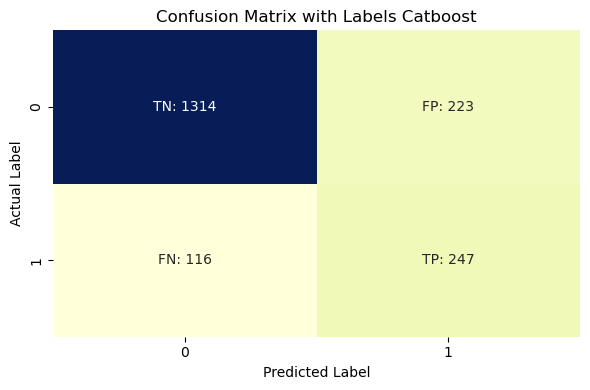

In [38]:

# Predict on the test set using your grid search model
y_pred = grid_search_cat.predict(X_test)

# Compute the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Define class names for display
class_names = [0, 1]  # Adjust if your labels differ

# Create a label array for annotation:
# For binary classification, assume:
#   - Top-left: True Negative (TN)
#   - Top-right: False Positive (FP)
#   - Bottom-left: False Negative (FN)
#   - Bottom-right: True Positive (TP)
labels = np.array([["TN", "FP"], ["FN", "TP"]])

# Prepare an annotation array with both labels and counts
annot = np.empty_like(cnf_matrix).astype(str)
for i in range(cnf_matrix.shape[0]):
    for j in range(cnf_matrix.shape[1]):
        annot[i, j] = f"{labels[i, j]}: {cnf_matrix[i, j]}"

# Plot the confusion matrix with annotations
fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(pd.DataFrame(cnf_matrix),
            annot=annot,
            fmt="",
            cmap="YlGnBu",
            cbar=False,
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix with Labels Catboost")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.tight_layout()
plt.show()


In [35]:

# Build a pipeline with feature selection, SMOTE, and XGBClassifier
pipeline_xgb = Pipeline([
    ('select_k_best', SelectKBest(score_func=f_classif, k=12)),
    ('sampling', SMOTE()),
    ('model', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

# Define a parameter grid for XGBoost
param_grid_xgb = {
    'select_k_best__k': [10, 12],            # Tune feature selection with two options
    'model__max_depth': [6, 8],              # Control tree depth
    'model__learning_rate': [0.01, 0.1],       # Adjust the learning rate
    'model__n_estimators': [100, 200],       # Number of boosting rounds
    'model__reg_lambda': [1, 3]              # L2 regularization strength (lambda)
}

# Setup GridSearchCV with the XGBoost pipeline
grid_search_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, scoring='recall', cv=5, n_jobs=-1, verbose=1)

# Fit GridSearchCV on training data
grid_search_xgb.fit(X_train, y_train)

# Best parameters and score
print("Best parameters:", grid_search_xgb.best_params_)
print("Best cross-validation accuracy:", grid_search_xgb.best_score_)

# Evaluate on the test set
test_score_xgb = grid_search_xgb.score(X_test, y_test)
print("Test set accuracy:", test_score_xgb)


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters: {'model__learning_rate': 0.01, 'model__max_depth': 6, 'model__n_estimators': 200, 'model__reg_lambda': 1, 'select_k_best__k': 10}
Best cross-validation accuracy: 0.7179310344827586
Test set accuracy: 0.7327823691460055


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.81      0.87      1537
           1       0.48      0.73      0.58       363

    accuracy                           0.80      1900
   macro avg       0.70      0.77      0.72      1900
weighted avg       0.84      0.80      0.81      1900



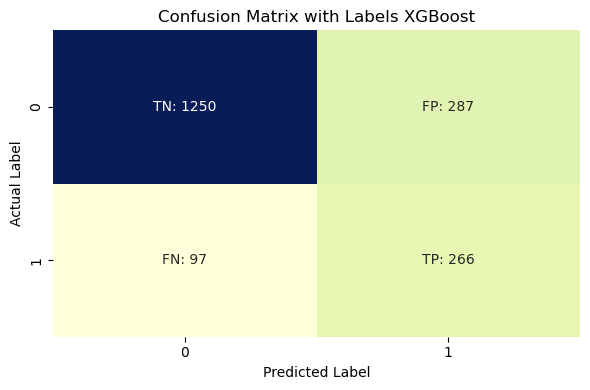

In [37]:

# Predict on the test set using your grid search model
y_pred = grid_search_xgb.predict(X_test)

# Compute the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Define class names for display
class_names = [0, 1]  # Adjust if your labels differ

# Create a label array for annotation:
# For binary classification, assume:
#   - Top-left: True Negative (TN)
#   - Top-right: False Positive (FP)
#   - Bottom-left: False Negative (FN)
#   - Bottom-right: True Positive (TP)
labels = np.array([["TN", "FP"], ["FN", "TP"]])

# Prepare an annotation array with both labels and counts
annot = np.empty_like(cnf_matrix).astype(str)
for i in range(cnf_matrix.shape[0]):
    for j in range(cnf_matrix.shape[1]):
        annot[i, j] = f"{labels[i, j]}: {cnf_matrix[i, j]}"

# Plot the confusion matrix with annotations
fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(pd.DataFrame(cnf_matrix),
            annot=annot,
            fmt="",
            cmap="YlGnBu",
            cbar=False,
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix with Labels XGBoost")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.tight_layout()
plt.show()


## Catboost export final model 

In [34]:

# Create the pipeline with  specified hyperparameters
pipeline_catboost = Pipeline([
    ('select_k_best', SelectKBest(score_func=f_classif, k=12)),
    ('sampling', SMOTE()),
    ('model', CatBoostClassifier(
        random_state=42, 
        verbose=0,
        class_weights=[1, 2],
        depth=6,
        iterations=200,
        l2_leaf_reg=3,
        learning_rate=0.1
    ))
])

# Fit the pipeline on your training data
pipeline_catboost.fit(X_train, y_train)

# Export (save) the fitted model to disk
joblib.dump(pipeline_catboost, 'catboost_pipeline.pkl')
print("Model exported as 'catboost_pipeline.pkl'")

# -------------------------------------------------------------------
# Extracting the selected feature names from the SelectKBest step
# -------------------------------------------------------------------

# Retrieve the fitted SelectKBest object from the pipeline
selector = pipeline_catboost.named_steps['select_k_best']

# Create a DataFrame with scores indexed by feature names
df_scores = pd.DataFrame(selector.scores_, index=X_train.columns, columns=["Score"])

# Get the names of the best 12 features (highest scores)
best_k_cols = df_scores.nlargest(12, "Score").index.values
print("Selected columns:", best_k_cols)


Model exported as 'catboost_pipeline.pkl'
Selected columns: ['Age' 'Geography_Germany' 'IsActiveMember' 'Balance' 'NumOfProducts'
 'Geography_France' 'Gender_Female' 'Gender_Male' 'Geography_Spain'
 'CreditScore' 'EstimatedSalary' 'Tenure']


## XGBoost export final model 

In [ ]:

# Create a pipeline with feature selection, SMOTE, and XGBClassifier
pipeline_xgb = Pipeline([
    ('select_k_best', SelectKBest(score_func=f_classif, k=10)),
    ('sampling', SMOTE()),
    ('model', XGBClassifier(
        random_state=42,
        learning_rate=0.01,
        max_depth=6,
        n_estimators=200,
        reg_lambda=1,
        use_label_encoder=False,
        eval_metric='logloss'
    ))
])

# Fit the pipeline on your training data
pipeline_xgb.fit(X_train, y_train)

# Export (save) the fitted model to disk
joblib.dump(pipeline_xgb, 'xgb_pipeline.pkl')
print("Model exported as 'xgb_pipeline.pkl'")

# -------------------------------------------------------------------
# Extracting the selected feature names from the SelectKBest step
# -------------------------------------------------------------------

# Retrieve the fitted SelectKBest object from the pipeline
selector = pipeline_xgb.named_steps['select_k_best']

# Create a DataFrame with scores indexed by the original feature names
df_scores = pd.DataFrame(selector.scores_, index=X_train.columns, columns=["Score"])

# Get the names of the best 10 features (highest scores)
best_k_cols = df_scores.nlargest(10, "Score").index.values
print("Selected columns:", best_k_cols)


Model exported as 'xgb_pipeline.pkl'
Selected columns: ['Age' 'Geography_Germany' 'IsActiveMember' 'Balance' 'NumOfProducts'
 'Geography_France' 'Gender_Female' 'Gender_Male' 'Geography_Spain'
 'HasCrCard']


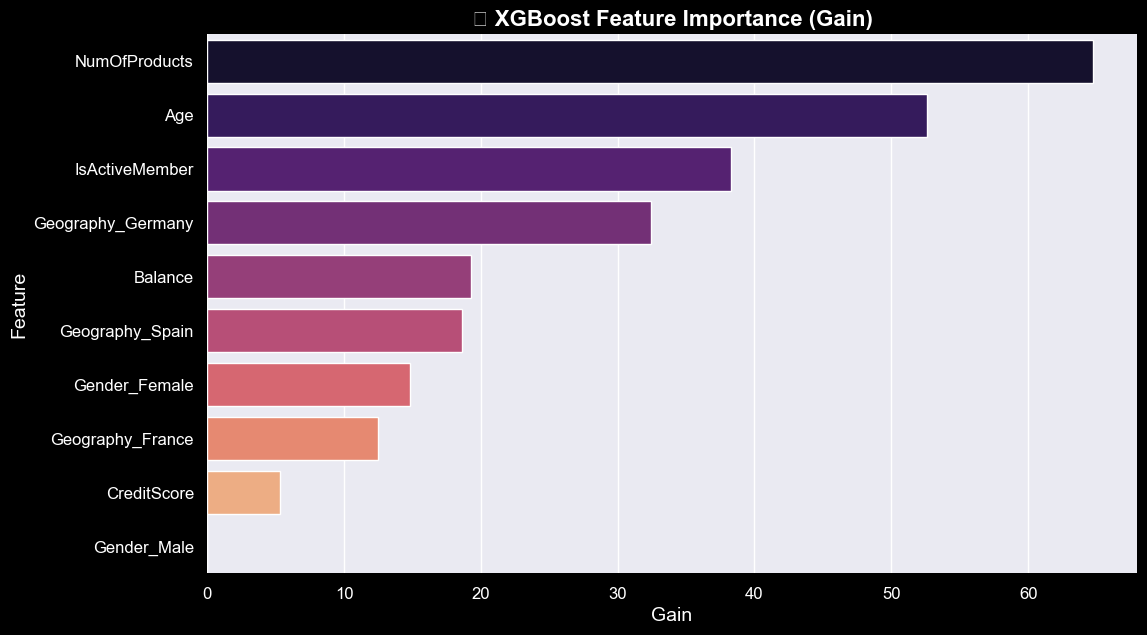

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import pandas as pd
import joblib

# Set Seaborn dark theme for better aesthetics
sns.set_theme(style="darkgrid")

# Load the trained XGBoost pipeline
pipeline_xgb = joblib.load(r"C:\Users\user\Desktop\Github\Bank Churn Prediction\Bank-Churn-Prediction\model\xgb_pipeline.pkl")

# Extract the trained model from the pipeline
xgb_model = pipeline_xgb.named_steps['model']

# Retrieve the selected feature names from SelectKBest
selected_features = pipeline_xgb.named_steps['select_k_best'].get_feature_names_out()

# Convert feature importance into a DataFrame
feature_importance = xgb_model.get_booster().get_score(importance_type='gain')

# Map feature names correctly
feature_importance_df = pd.DataFrame({
    'Feature': selected_features,  # Use actual feature names
    'Importance': [feature_importance.get(f"f{i}", 0) for i in range(len(selected_features))]
})

# Sort by importance (highest first)
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=True)  # Sorted in ascending order for proper display

# Define a modern color palette (dark mode friendly)
colors = sns.color_palette("magma_r", len(feature_importance_df))

# Create the figure with a dark background
plt.figure(figsize=(12, 7), facecolor='black')  
ax = sns.barplot(
    y=feature_importance_df['Feature'], 
    x=feature_importance_df['Importance'], 
    palette=colors
)

# Improve aesthetics
plt.xlabel("Gain", fontsize=14, color='white')
plt.ylabel("Feature", fontsize=14, color='white')
plt.title("🔍 XGBoost Feature Importance (Gain)", fontsize=16, color='white', fontweight='bold')

# Adjust tick labels
ax.tick_params(colors='white', labelsize=12)

# Ensure best features appear at the **top**
plt.gca().invert_yaxis()

# Remove unnecessary grid lines for a cleaner look
sns.despine(left=True, bottom=True)

plt.show()
